<a href="https://colab.research.google.com/github/whkaikai/-python-/blob/main/VGGUntitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#@title <b><font color="blue" size="+2">Install the all needed libraries { display-mode: "form" }
%%time

import pandas as pd
import os 
import cv2 
import h5py
import random
import pathlib
import numpy as np

import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt
import sys, os

from glob import glob
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as keras
from sklearn.manifold import TSNE
from tensorflow.keras import datasets
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import  plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CPU times: user 110 µs, sys: 0 ns, total: 110 µs
Wall time: 116 µs


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
%%bash
pwd
cd drive/MyDrive

/content


In [35]:
#@title <b><font color="gree" size="+2">Define the path for the image{display-mode: "form"}

# Train_path = './Train'
# Val_path = './Validation'

Train_path = '/content/drive/MyDrive/Train'
Val_path = '/content/drive/MyDrive/Validation'

images=os.listdir(Train_path)
val_images=os.listdir(Val_path)
print(f"the folder of images: {images}")
print(f"the folder of images: {val_images}")

the folder of images: ['.DS_Store', 'WithMask', 'WithoutMask']
the folder of images: ['.DS_Store', 'WithMask', 'WithoutMask']


In [36]:
IMAGE_SIZE = [100,100]

In [37]:
# number of files
train_image_files = glob(Train_path + '/*/*.png')
valid_image_files = glob(Val_path + '/*/*.png')

In [38]:
#@title <b><font color="red" size="+2"> Setup GPU Strategy {display-mode: "form"}
# Note that it generally has a minimum of 8 cores, but if your GPU has
# less, you need to set this. In this case one of my GPUs has 4 cores
# os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "4"

# If the list of devices is not specified in the
# `tf.distribute.MirroredStrategy` constructor, it will be auto-detected.
# If you have *different* GPUs in your system, you probably have to set up cross_device_ops like this
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

# one_strategy = tf.distribute.OneDeviceStrategy(device=gpu_name)  # one-device-strategy
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [39]:
#@title <b><font color="black" size="+2"> Setup TPU Strategy if use TPU {display-mode: "form"}
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Deal input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, is better to store our input data in TFRecord files. 
500 images for two classes, with or without mask.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.

All of these techniques are a bit overkill for our (small) dataset, but demonstrate best practices for using TPUs.

In [40]:
#@title <b><font color="blue" size="+2">  ImageDataGenerator{display-mode: "form"}
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

training_set = train_datagen.flow_from_directory(Train_path,
                                                 target_size = (32, 32),
                                                 interpolation="nearest",
                                                 class_mode='binary',
                                                 classes=["WithoutMask","WithMask"])

validation_set = val_datagen.flow_from_directory(Val_path,
                                                 target_size=(32, 32),
                                                 interpolation="nearest",
                                                 class_mode='binary',
                                                 classes=["WithoutMask","WithMask"])

Found 57 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


trainX: WithMask; trainY: WithoutMask;

---

valX: WithMask; valY: WithoutMask;

In [41]:
# number of classes
folders = glob(Train_path + '/*')
folders

['/content/drive/MyDrive/Train/WithMask',
 '/content/drive/MyDrive/Train/WithoutMask']

# Get Features(XY variable)

In [42]:
def GetXY(gen):
    listX = []
    listY = []
    for i in range(gen.__len__()):
        gennext = gen.next()
        listX.append(gennext[0])
        listY.append(gennext[1])
    x=np.concatenate(listX)
    y=np.concatenate(listY)
    return (x,y)

with strategy.scope():  # use the GPU strategy, if no GPU, will continue use CPU, no need to change code so it is convenient
  trainX,trainY = GetXY(training_set)  # now the size of train is equal to the size of validation
  valX,valY = GetXY(validation_set)

print(f"the shape of train X is: {trainX.shape}")
print(f"the shape of train Y is: {trainY.shape}")
print(f"the shape of val X is: {valX.shape}")
print(f"the shape of val Y is: {valY.shape}")

ImageTrainXNumber = trainX.shape[0]
ImageTrainYNumber = trainY.shape[0]

ImageValXNumber = valX.shape[0]
ImageValYNumber = valY.shape[0]

the shape of train X is: (57, 32, 32, 3)
the shape of train Y is: (57,)
the shape of val X is: (28, 32, 32, 3)
the shape of val Y is: (28,)


# Use VGG-16 model

---

VGG-16 has 16 layers, and we use only upper 13 layers in our model. 



In [43]:
with strategy.scope():  # use the GPU strategy
  model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(32,32, 3))
  for layers in model_vgg.layers:
      layers.trainable = False

  trainX1, valX1 = model_vgg.predict(trainX), model_vgg.predict(valX)

  # tsne=TSNE()
  # t= tsne.fit_transform(trainX1.reshape(trainX1_size,-1) ) 
  # print(f"the shape of t is {t.shape}")

print(f"\nthe shape of trainX1 (trained with train X) is {trainX1.shape}\nOriginal train X shape is {trainX.shape}")
print(f"\nthe shape of valX1 (trained with val X) is {valX1.shape}\nOriginal val X shape is {valX.shape}")

trainX1_size = trainX1.shape[0] * trainX1.shape[-1]


the shape of trainX1 (trained with train X) is (57, 1, 1, 512)
Original train X shape is (57, 32, 32, 3)

the shape of valX1 (trained with val X) is (28, 1, 1, 512)
Original val X shape is (28, 32, 32, 3)


In [44]:
# model_vgg.summary()

In [45]:
with strategy.scope():
  valX1=valX1.reshape(valX1.shape[-1], -1)  # (800,-1)
  trainX1=trainX1.reshape(ImageTrainXNumber, -1)  # (10000,-1)
  valY=valY.reshape(valX1.shape[-1], 1)  # 800, 1
  trainY=trainY.reshape(ImageTrainYNumber, 1)  # 10000, 1

In [46]:
import matplotlib.pyplot as plt
from pylab import *

plt.rcParams['figure.dpi'] = 100 #分辨率
fig = plt.figure(figsize=[15,6])

plt.show()

<Figure size 1500x600 with 0 Axes>

# Get matlabdata.mat

In [47]:
import scipy.io as scio

scio.savemat('./matlabdata.mat', dict([('valX1', valX1),
                                       ('trainX1', trainX1),
                                      ('valY',valY),
                                       ('trainY', trainY)])) 

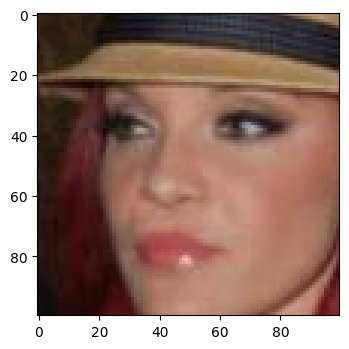

In [48]:
# random image
plt.imshow(image.load_img(np.random.choice(train_image_files)))

In [49]:
ptm = VGG16(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False
)

In [50]:
# freezing VGG16 Model weights
ptm.trainable = False

In [51]:
# map data into feature vectors

K = len(folders) # no. of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [52]:
model = Model(inputs=ptm.input, outputs=x)

In [53]:
#model.summary()

In [54]:
# ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [55]:
# Generator

batch_size = 128

train_generator = gen.flow_from_directory(
    Train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

valid_generator = gen.flow_from_directory(
    Val_path,
    shuffle=False,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 57 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [56]:
model.compile(
    loss='categorical_crossentropy',  # as generator yields one-hit encoded results
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(train_image_files)/batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files)/batch_size))
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 12.4690 - accuracy: 0.4561 - val_loss: 8.2432 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 596ms/step - loss: 6.6020 - accuracy: 0.5439 - val_loss: 7.0800 - val_accuracy: 0.6429
Epoch 3/10
1/1 [==============================] - 1s 566ms/step - loss: 4.2850 - accuracy: 0.6316 - val_loss: 2.2204 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 1s 575ms/step - loss: 1.3398 - accuracy: 0.8070 - val_loss: 4.3857 - val_accuracy: 0.6786
Epoch 5/10
1/1 [==============================] - 1s 572ms/step - loss: 1.2819 - accuracy: 0.8246 - val_loss: 0.9041 - val_accuracy: 0.9286
Epoch 6/10
1/1 [==============================] - 1s 583ms/step - loss: 0.6673 - accuracy: 0.9298 - val_loss: 1.4174 - val_accuracy: 0.8571
Epoch 7/10
1/1 [==============================] - 1s 576ms/step - loss: 0.2728 - accuracy: 0.9649 - val_loss: 0.4271 - val_accuracy: 0.8571
Epoch 8/10
1/1 [======

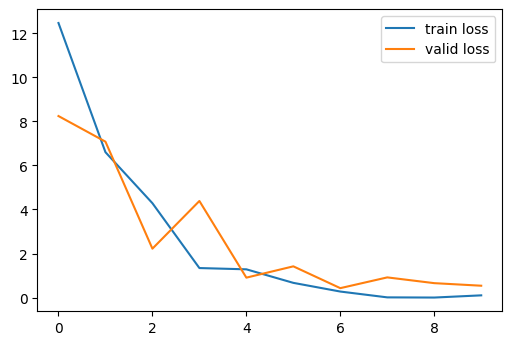

In [58]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()

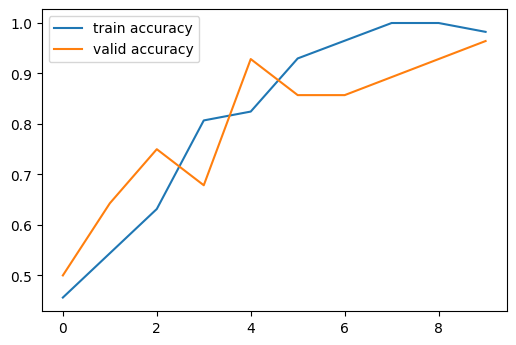

In [59]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend()